In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [5]:
anchor = tf.data.Dataset.list_files('/content/data/anchor' +'/*.jpg').take(200)
positive = tf.data.Dataset.list_files('/content/data/positive' +'/*.jpg').take(200)
negative = tf.data.Dataset.list_files('/content/data/negative' +'/*.jpg').take(200)

In [20]:
di = anchor.as_numpy_iterator()
di.next()


b'/content/data/anchor/2022-08-31-210725.jpg'

# **PreProcess Data**

In [7]:
def preprocess(file_path):
    img = tf.io.read_file(file_path)
    image1 = tf.io.decode_jpeg(img)
    image1 = tf.image.resize(image1, (100,100))
    image1 = image1/255.0
    return image1

In [21]:
IMAGE =preprocess(b'/content/data/anchor/2022-08-31-210725.jpg')

In [22]:
IMAGE.numpy().min()

0.26062754

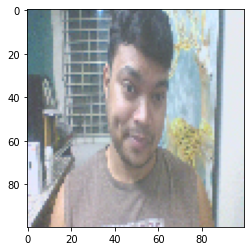

In [23]:
plt.imshow(IMAGE)

In [24]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [25]:
sample = data.as_numpy_iterator()
example = sample.next()
example

(b'/content/data/anchor/2022-08-31-210624.jpg',
 b'/content/data/positive/2022-08-31-210747 (4).jpg',
 1.0)

## **Build Train and Test**

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
res =preprocess_twin(*example)
len(res)

3

In [28]:
# build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [29]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [30]:
sample = data.as_numpy_iterator()
len(sample.next())

3

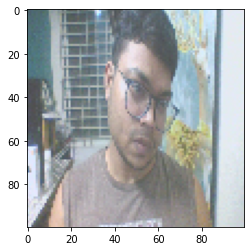

In [41]:
samp = sample.next()
plt.imshow(samp[0])

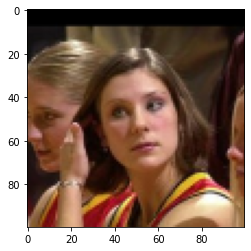

In [42]:
plt.imshow(samp[1])

In [43]:
samp[2]

0.0

In [44]:
# training partition

train_data = data.take(round(len(data)*0.7))

train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [45]:
# testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.7))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## **Model Building**

In [46]:
# Build Embedding layer
def make_embedding():
  input = Input(shape=(100,100,3), name ='Input_Image')

  #First block
  X = Conv2D(64,(10,10), activation = "relu")(input)
  X = MaxPooling2D(64,(2,2), padding = "same")(X)

  # second block
  Y = Conv2D(128,(7,7), activation= "relu")(X)
  Y = MaxPooling2D(64,(2,2), padding = "same")(Y)

  #third block
  Z = Conv2D(128,(7,7), activation= "relu")(Y)
  Z = MaxPooling2D(64,(2,2), padding = "same")(Z)

  # final embedding block
  Z = Conv2D(256,(4,4), activation= "relu")(Z)
  Z = Flatten()(Z)
  out = Dense(4096, activation = "sigmoid")(Z)

  return Model(inputs = [input], outputs = [out], name = "embedding")

In [47]:
embedding = make_embedding()

In [48]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       80

## **Build Distance layer**

In [49]:
# Siamese L1 Distance class
class L1Dist(Layer):
  def __init__(self, **kwargs):
    super().__init__()

  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding) 

In [50]:
def _siamese_model():

  # anchor image input
  input_image = Input(name ="input_img", shape = (100,100,3))

  # validation image
  validation_image = Input(name = "validation_img", shape = (100,100,3))

  # combine siamese distance
  siamese_layer = L1Dist()
  siamese_layer._name = "distance"
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # classification layer
  classifier = Dense(1, activation = "sigmoid")(distances)

  return Model(inputs = [input_image, validation_image], outputs = classifier, name = "Siamese_Network")


In [51]:
sia_model = _siamese_model()

In [52]:
sia_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         18529600    ['input_img[0][0]',              
                                                                  'validation_img[0]

## **Training model**

In [53]:
# setup loss and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

opt =tf.keras.optimizers.Adam(1e-4)

In [54]:
# Establish Checkpoints
checkpoint_dir = "/content/training_checkpoint"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = sia_model)

In [55]:
# build train step function
@tf.function
def train_step(batch):
  
  with tf.GradientTape() as tape:

    x = batch[:2]

    y = batch[2]

    yhat = sia_model(x, training =True)

    loss = binary_cross_loss(y, yhat)
  print(loss)  

  grad = tape.gradient(loss, sia_model.trainable_variables)

  opt.apply_gradients(zip(grad, sia_model.trainable_variables))
  return loss  



In [56]:
# building training loop
def train(data, EPOCHS):
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    # loop through each batch
    for idx, batch in enumerate(data):
      train_step(batch)
      progbar.update(idx+1)

     # save checkpoints
    if epoch % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix) 

In [57]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
18/18 [==============================] - 16s 205ms/step

 Epoch 2/50
18/18 [==============================] - 3s 177ms/step

 Epoch 3/50
18/18 [==============================] - 3s 177ms/step

 Epoch 4/50
18/18 [==============================] - 3s 181ms/step

 Epoch 5/50
18/18 [==============================] - 3s 174ms/step

 Epoch 6/50
18/18 [==============================] - 3s 175ms/step

 Epoch 7/50
18/18 [==============================] - 3s 175ms/step

 Epoch 8/50
18/18 [==============================] - 3s 178ms/step

 Epoch 9/50
18/18 [==============================] - 3s 179ms/step

 Epoch 10/50
18/18 [==============================] - 3s 179ms/step

 Epoch 11/50
18/18 [==============================] - 3s 178ms/step

 Epoch 12/50
18/18 [==============================] - 3s 178ms/step

 Epoch 13/50
18/18 [=====

In [61]:
## Evaluation 
from tensorflow.keras.metrics import Precision, Recall

test_input, test_val, y_true = test_data.as_numpy_iterator().next()

# **Predictions**

In [62]:
y_hat = sia_model.predict([test_input, test_val])
y_hat

array([[4.1299826e-09],
       [1.0000000e+00],
       [6.7703128e-09],
       [5.4181794e-07],
       [9.9992669e-01],
       [9.9960822e-01],
       [9.9936968e-01],
       [1.0000000e+00],
       [2.2440672e-06],
       [2.2729452e-07],
       [4.2689567e-09],
       [2.3828184e-08],
       [3.7645251e-09],
       [3.7707079e-07],
       [5.0568896e-09],
       [1.1169172e-06]], dtype=float32)

In [63]:
# post processing results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [64]:
y_true

array([0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [65]:
# creatind metric object
m = Recall()
# calculate recall value
m.update_state(y_true, y_hat)

# return results
m.result().numpy()


1.0

In [66]:
# creatind metric object
m = Precision()
# calculate precision value
m.update_state(y_true, y_hat)

# return results
m.result().numpy()


1.0

# **EXAMPLES**

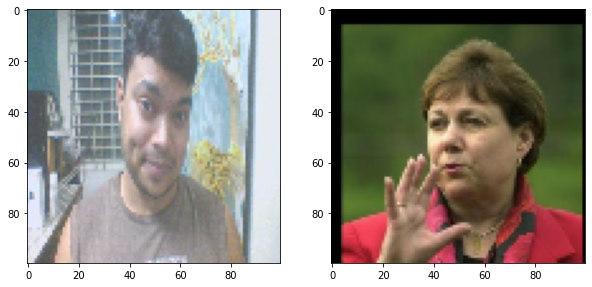

In [67]:
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [68]:
## Save model
sia_model.save('face_recognition.h5')

In [80]:
!echo "# Face-Recognition" >> README.md
!git init

Reinitialized existing Git repository in /content/.git/


In [81]:
!git add README.md

In [82]:
!git commit -m "first commit"
!git branch -M main


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@14ea23c3752a.(none)')
error: refname refs/heads/master not found
fatal: Branch rename failed


In [96]:
!git config  --global user.email "amaner24@gmail.com.com"

In [97]:
!git config --global user.name "amansaini005"

In [98]:
!git commit -m "first commit"
!git branch -M main

On branch main
Untracked files:
	.config/
	data/
	drive/
	face_recognition.h5
	sample_data/
	training_checkpoint/

nothing added to commit but untracked files present
